## Notebook Goals
- using food101 (research & data) as an inspiration, build a machine-learning model that can recognize food in images
- download & use data from the tensorflow_datasets lib

## Get helper Functions

In [1]:
# Get helper functions file
import os 
import matplotlib.pyplot as plt

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

dir_path = os.path.dirname(os.path.realpath(os.getcwd()))
print(f'current dirPath: {dir_path}')

[INFO] 'helper_functions.py' already exists, skipping download.
current dirPath: /home


## Imports

In [2]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

# 
# data-scient + ML
# 
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys
import tensorflow_datasets as tfds

TensorFlow version: 2.15.0
Notebook last run (end-to-end): 2024-07-09 12:17:51.731064


## Get Data

In [3]:
# 
# detect if the dataset is, indeed, in the tensorflow_datasets world
# 

# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

2024-07-09 12:17:53.380161: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


'food101' in TensorFlow Datasets: True


In [4]:
# 
# get the data
# *** *** *** WARNING
#             downloads 5g of images
# *** *** *** WARNING

# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name=target_dataset, # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

### Explore Data
- shape
- datatype
- labels
- labels compared to classnames

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
# Get class names
class_names = ds_info.features["label"].names
print(f'{len(class_names)} classes')
print(class_names[:10])

101 classes
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [7]:
# 
# get a single sample of the data
# 
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
# view the data in the sample
# 
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Label (tensor form): {label}
  label-to-Class(str form): {class_names[label.numpy()]}
        """)


  Image shape: (489, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Label (tensor form): 90
  label-to-Class(str form): spaghetti_bolognese
        


### Explore Image

In [9]:
image

<tf.Tensor: shape=(489, 512, 3), dtype=uint8, numpy=
array([[[ 83,  71,  45],
        [ 81,  69,  43],
        [ 80,  68,  44],
        ...,
        [186, 183, 142],
        [188, 185, 144],
        [185, 182, 141]],

       [[ 86,  74,  48],
        [ 83,  71,  45],
        [ 82,  70,  46],
        ...,
        [180, 177, 136],
        [179, 176, 135],
        [182, 179, 138]],

       [[ 88,  76,  52],
        [ 87,  75,  51],
        [ 85,  73,  49],
        ...,
        [188, 185, 144],
        [186, 183, 142],
        [187, 184, 143]],

       ...,

       [[162, 163, 168],
        [164, 165, 170],
        [171, 170, 176],
        ...,
        [ 75,  74,  56],
        [ 67,  66,  48],
        [ 64,  63,  45]],

       [[168, 169, 174],
        [175, 176, 181],
        [167, 166, 172],
        ...,
        [ 79,  78,  60],
        [ 74,  73,  55],
        [ 79,  78,  60]],

       [[182, 183, 188],
        [178, 179, 184],
        [163, 164, 169],
        ...,
        [ 75,  74,  5

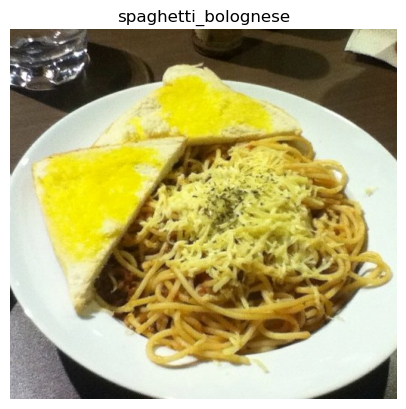

In [10]:
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

### Resize & TypeCast Images
Tensorflow models like images that...
- are `float32` dtype
- contain uniform tensor sizes across images and batches of images
- number values to be scaled

Luckily, tensorflow pre-trianed models like efficientNet contain the re-scaling detail in the model!  

In [11]:
def resizeAndType(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [12]:
# get a singlee sample image and check the outputs
preprocessed_img = resizeAndType(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 83  71  45]
  [ 81  69  43]
  [ 80  68  44]
  ...
  [186 183 142]
  [188 185 144]
  [185 182 141]]

 [[ 86  74  48]
  [ 83  71  45]
  [ 82  70  46]
  ...
  [180 177 136]
  [179 176 135]
  [182 179 138]]]...,
Shape: (489, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 83.108574  71.108574  45.108578]
  [ 82.11161   70.11161   46.11161 ]
  [ 84.873245  72.873245  49.30182 ]
  ...
  [191.5464   188.5464   147.5464  ]
  [184.01991  181.01991  140.01991 ]
  [182.87247  179.87247  138.87247 ]]

 [[ 87.08051   75.08051   51.080517]
  [ 84.33609   72.33609   48.336098]
  [ 83.439735  70.796875  47.439735]
  ...
  [198.13402  195.13402  154.13402 ]
  [194.08138  191.08138  150.08138 ]
  [193.38318  190.38318  149.38318 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


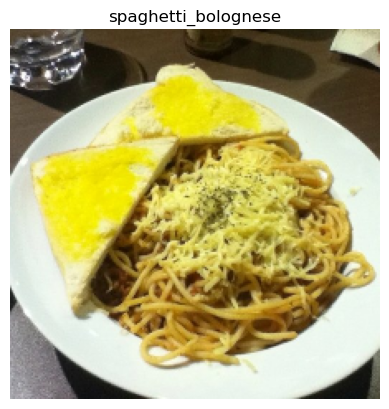

In [13]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

### Batch DataSets
For reference, tensorflow has a great doc on [creating performant data-processing pipelines](https://www.tensorflow.org/guide/data_performance):
- computation on batches is more memory-efficient than across an entire dataset
- images get converted into tensors & labels

Batching will happen with...
- `map`: apply a fn to each iteration in a list
- `shuffle`: random shuffle
- `batch`: group items into batches
- `prefetch`: pre-fetch batches while other batches are being computed on
- `cache`: save items in the dataset in a cache
- **NOTES**:
  - batching can onlyhappen on tensors of the same shape
  - shuffling is based on a size of a shuffle buffer. Ideally, the buffer sits fits all of the date being shuffled. Large enough datasets will not fit in cache.
  - some methods can use a param `num_parallel_calls`. `num_parallel_calls=tf.data.AUTOTUNE` will improve the speed of the logic due to parallel logic!

In [14]:
# 
# TRAINING DATA
#   resizeAndType
#   shuffle, batch, prefetch
# 
resizedTrainedData = train_data.map(map_func=resizeAndType, num_parallel_calls=tf.data.AUTOTUNE)
preparedTrainingData = resizedTrainedData.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# 
# TESTING DATA
#   resizeAndType
#   batch, prefetch (NO SHUFFLE)
# 
resizedTestData = test_data.map(resizeAndType, num_parallel_calls=tf.data.AUTOTUNE)
preparedTestingData = resizedTestData.batch(32).prefetch(tf.data.AUTOTUNE)

## Build Model
### Callbacks: tensorboard and modelCheckpoint

In [15]:
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

### Enable Mixed-Precision Training
#### Mixed-Precision Training
[see docs](https://www.tensorflow.org/guide/mixed_precision)
Tensorflow defaults to datatype `float32` for tensors unless specified during tensor creation.  
Mixed-precision uses `float32` AND `float16`, leveraging the smaller where possible.  
32-bit or 16-bit.  
This mixed-precision enables tensorflow to use less memory where it figures out that it can.  
Using less memory will enable tensorflow to run faster.  
Enabling mixed-precision requires a GPU with capability of at least 7.0.

On the machine I'm currently using, I get a warning when running the two below lines, the import and the `set_global_policy`:
```python
WARNING:tensorflow:Mixed precision compatibility check (mixed_float16): WARNING
The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once```

In [17]:
# Turn on mixed precision training
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 